<a href="https://colab.research.google.com/github/srijayjk/Computer-Vision/blob/main/Denosing_AE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.layers import Conv2D, Flatten
from tensorflow.keras.layers import Reshape, Conv2DTranspose
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
from tensorflow.keras.datasets import mnist
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

np.random.seed(1337)

In [2]:
# load MNIST dataset
(x_train, _), (x_test, _) = mnist.load_data()

11493376/11490434 [==============================] - 0s 0us/step


In [3]:
# reshape to (28, 28, 1) and normalize input images
image_size = x_train.shape[1]
x_train = np.reshape(x_train, [-1, image_size, image_size, 1])
x_test = np.reshape(x_test, [-1, image_size, image_size, 1])
x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255

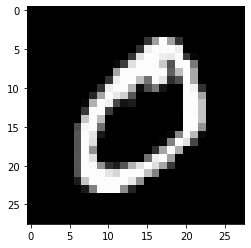

In [10]:
pixels = x_train[1].reshape((28, 28))
plt.imshow(pixels, cmap='gray')
plt.show()

# adding noise

In [12]:
# generate corrupted MNIST images by adding noise with normal dist
# centered at 0.5 and std=0.5
noise = np.random.normal(loc=0.5, scale=0.5, size=x_train.shape)
x_train_noisy = x_train + noise
noise = np.random.normal(loc=0.5, scale=0.5, size=x_test.shape)
x_test_noisy = x_test + noise

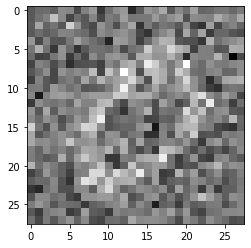

In [13]:
pixels = x_train_noisy[1].reshape((28, 28))
plt.imshow(pixels, cmap='gray')
plt.show()

In [14]:
# adding noise may exceed normalized pixel values>1.0 or <0.0
# clip pixel values >1.0 to 1.0 and <0.0 to 0.0
x_train_noisy = np.clip(x_train_noisy, 0., 1.)
x_test_noisy = np.clip(x_test_noisy, 0., 1.)

In [18]:
# network parameters
input_shape = (image_size, image_size, 1)
batch_size = 32
kernel_size = 3
latent_dim = 20
# encoder/decoder number of CNN layers and filters per layer
layer_filters = [32, 64]

# build the autoencoder model


In [19]:
inputs = Input(shape=input_shape, name='encoder_input')
x = inputs

# stack of Conv2D(32)-Conv2D(64)
for filters in layer_filters:
    x = Conv2D(filters=filters,
               kernel_size=kernel_size,
               strides=2,
               activation='relu',
               padding='same')(x)

# shape info needed to build decoder model so we don't do hand computation
# the input to the decoder's first Conv2DTranspose will have this shape
# shape is (7, 7, 64) which can be processed by the decoder back to (28, 28, 1)
shape = K.int_shape(x)

# generate the latent vector
x = Flatten()(x)
latent = Dense(latent_dim, name='latent_vector')(x)

# instantiate encoder model
encoder = Model(inputs, latent, name='encoder')
encoder.summary()

Model: "encoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder_input (InputLayer)   [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 14, 14, 32)        320       
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 7, 7, 64)          18496     
_________________________________________________________________
flatten_1 (Flatten)          (None, 3136)              0         
_________________________________________________________________
latent_vector (Dense)        (None, 20)                62740     
Total params: 81,556
Trainable params: 81,556
Non-trainable params: 0
_________________________________________________________________


# build the decoder model


In [20]:
latent_inputs = Input(shape=(latent_dim,), name='decoder_input')
# use the shape (7, 7, 64) that was earlier saved
x = Dense(shape[1] * shape[2] * shape[3])(latent_inputs)
# from vector to suitable shape for transposed conv
x = Reshape((shape[1], shape[2], shape[3]))(x)

# stack of Conv2DTranspose(64)-Conv2DTranspose(32)
for filters in layer_filters[::-1]:
    x = Conv2DTranspose(filters=filters,
                        kernel_size=kernel_size,
                        strides=2,
                        activation='relu',
                        padding='same')(x)

# reconstruct the denoised input
outputs = Conv2DTranspose(filters=1,
                          kernel_size=kernel_size,
                          padding='same',
                          activation='sigmoid',
                          name='decoder_output')(x)

# instantiate decoder model
decoder = Model(latent_inputs, outputs, name='decoder')
decoder.summary()

Model: "decoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
decoder_input (InputLayer)   [(None, 20)]              0         
_________________________________________________________________
dense (Dense)                (None, 3136)              65856     
_________________________________________________________________
reshape (Reshape)            (None, 7, 7, 64)          0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 14, 14, 64)        36928     
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 28, 28, 32)        18464     
_________________________________________________________________
decoder_output (Conv2DTransp (None, 28, 28, 1)         289       
Total params: 121,537
Trainable params: 121,537
Non-trainable params: 0
_____________________________________________________

# autoencoder = encoder + decoder


In [21]:
autoencoder = Model(inputs, decoder(encoder(inputs)), name='autoencoder')
autoencoder.summary()

Model: "autoencoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder_input (InputLayer)   [(None, 28, 28, 1)]       0         
_________________________________________________________________
encoder (Functional)         (None, 20)                81556     
_________________________________________________________________
decoder (Functional)         (None, 28, 28, 1)         121537    
Total params: 203,093
Trainable params: 203,093
Non-trainable params: 0
_________________________________________________________________


In [22]:
autoencoder.compile(loss='mse', optimizer='adam')

In [23]:
autoencoder.fit(x_train_noisy,
                x_train,
                validation_data=(x_test_noisy, x_test),
                epochs=10,
                batch_size=batch_size, verbose=1)


Epoch 1/10
1875/1875 [==============================] - 42s 7ms/step - loss: 0.0347 - val_loss: 0.0182
Epoch 2/10
1875/1875 [==============================] - 13s 7ms/step - loss: 0.0174 - val_loss: 0.0162
Epoch 3/10
1875/1875 [==============================] - 13s 7ms/step - loss: 0.0160 - val_loss: 0.0155
Epoch 4/10
1875/1875 [==============================] - 13s 7ms/step - loss: 0.0153 - val_loss: 0.0151
Epoch 5/10
1875/1875 [==============================] - 13s 7ms/step - loss: 0.0148 - val_loss: 0.0148
Epoch 6/10
1875/1875 [==============================] - 13s 7ms/step - loss: 0.0145 - val_loss: 0.0147
Epoch 7/10
1875/1875 [==============================] - 13s 7ms/step - loss: 0.0142 - val_loss: 0.0147
Epoch 8/10
1875/1875 [==============================] - 13s 7ms/step - loss: 0.0140 - val_loss: 0.0143
Epoch 9/10
1875/1875 [==============================] - 13s 7ms/step - loss: 0.0139 - val_loss: 0.0143
Epoch 10/10
1875/1875 [==============================] - 13s 7ms/step - l

In [24]:
x_decoded = autoencoder.predict(x_test_noisy)

Denoised Image

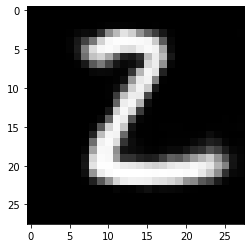

In [33]:
pixels = x_decoded[1].reshape((28, 28))
plt.imshow(pixels, cmap='gray')
plt.show()

# Original Image

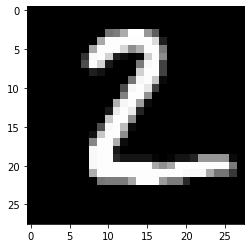

In [34]:
pixels = x_test[1].reshape((28, 28))
plt.imshow(pixels, cmap='gray')
plt.show()

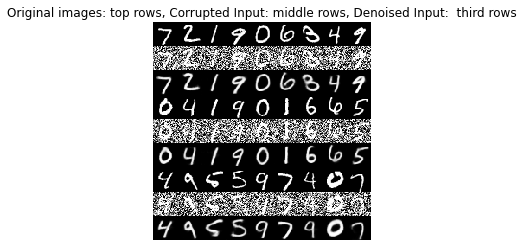

In [32]:
# 3 sets of images with 9 MNIST digits
# 1st rows - original images
# 2nd rows - images corrupted by noise
# 3rd rows - denoised images
rows, cols = 3, 9
num = rows * cols
imgs = np.concatenate([x_test[:num], x_test_noisy[:num], x_decoded[:num]])
imgs = imgs.reshape((rows * 3, cols, image_size, image_size))
imgs = np.vstack(np.split(imgs, rows, axis=1))
imgs = imgs.reshape((rows * 3, -1, image_size, image_size))
imgs = np.vstack([np.hstack(i) for i in imgs])
imgs = (imgs * 255).astype(np.uint8)
plt.figure()
plt.axis('off')
plt.title('Original images: top rows, '
          'Corrupted Input: middle rows, '
          'Denoised Input:  third rows')
plt.imshow(imgs, interpolation='none', cmap='gray')
Image.fromarray(imgs).save('corrupted_and_denoised.png')
plt.show()

Complete